<h1>Análisis Exploratorio de Datos

En este Notebook se realiza el análisis exploratorio de datos (EDA) con los conjuntos de datos previamente trabajados para posteriormente poder realizar el modelo de recomendación.

<h2>Importaciones

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

Se crea función para conocer cuántos datos únicos hay en una columna de dataframe y el porcentaje que estos representan.

In [2]:
def dataPercentage(df, column):
    counts = df[column].value_counts()
    percentages = round(100*counts/len(df),2)
    dfResults = pd.DataFrame({
        "Cantidad":counts,
        "Porcentaje":percentages
    })
    return dfResults

Se crea función para saber el tipo de dato que hay en las funciones, incluyendo el porcentaje de nulos.

In [3]:
def dataType(df):
        dfDict = {"name":[],"data_type":[],"not_null_%":[],"null_%":[],"null":[]}
        for column in df.columns:
                notNull=(df[column].count() / len(df)) * 100
                dfDict["name"].append(column)
                dfDict["data_type"].append(df[column].apply(type).unique())
                dfDict["not_null_%"].append(round(notNull, 2))
                dfDict["null_%"].append(round(100-notNull, 2))
                dfDict["null"].append(df[column].isnull().sum())
        dataTypeDf=pd.DataFrame(dfDict)
        return dataTypeDf

Se crea función para asignar un puntaje de recomendación de acuerdo al análisis de sentimiento, esto nos ayudará para el modelo de aprendizaje y se explicará más adelante.

In [4]:
def recommendScore(row):
    if not row['recommend']:
        return 0
    elif row['sentiment_analysis'] == 0:
        return 1
    elif row['sentiment_analysis'] == 1:
        return 2
    elif row['sentiment_analysis'] == 2:
        return 3
    else: 
        return None

<h2>Dataset steamGames

Se cargan los datasets y se crean los dataframes correspondientes.

In [5]:
steamGamesDf = pd.read_parquet('../data/steamGames.parquet')
steamGamesGenresExplodedDf = pd.read_parquet('../data/steamGamesGenresExploded.parquet')
steamGamesPriceDf = pd.read_parquet('../data/steamGamesPrice.parquet')

In [6]:
steamGamesDf.head(1)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer,release_year
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,2018


Visualizamos el porcentaje de nulos en el dataframe steamGamesDf

In [7]:
dataType(steamGamesDf)

,name,data_type,not_null_%,null_%,null
0,publisher,"[<class 'str'>, <class 'NoneType'>]",74.94,25.06,8052
1,genres,"[<class 'numpy.ndarray'>, <class 'NoneType'>]",89.78,10.22,3283
2,app_name,"[<class 'str'>, <class 'NoneType'>]",99.99,0.01,2
3,title,"[<class 'str'>, <class 'NoneType'>]",93.62,6.38,2050
4,url,[<class 'str'>],100.00,0.00,0
5,release_date,[<class 'pandas._libs.tslibs.timestamps.Timest...,93.03,6.97,2241
6,tags,"[<class 'numpy.ndarray'>, <class 'NoneType'>]",99.49,0.51,163
7,reviews_url,"[<class 'str'>, <class 'NoneType'>]",99.99,0.01,2
8,specs,"[<class 'numpy.ndarray'>, <class 'NoneType'>]",97.92,2.08,670
9,price,[<class 'float'>],95.71,4.29,1377


Consultamos el total de juegos únicos.

In [8]:
len(steamGamesDf['item_id'].unique())

32133

Creamos un gráfico que nos permita visualizar el top 5 de publishers y developers con más juegos publicados/desarrollados.

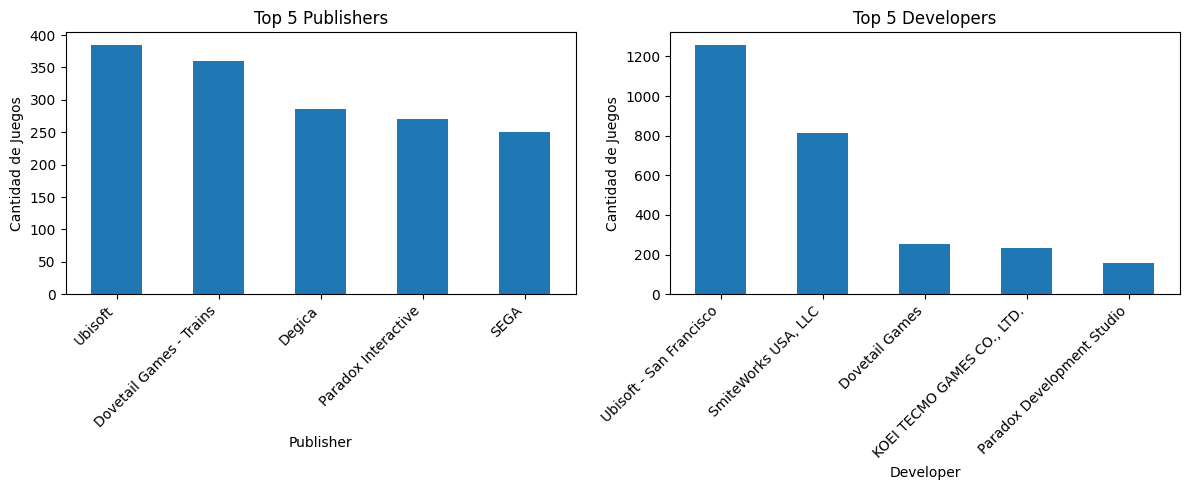

In [9]:
# Contar la cantidad de juegos por publisher y developer
pubCount = steamGamesDf['publisher'].value_counts()
devCount = steamGamesDf['developer'].value_counts()
# Creamos la gráfica con dos subplots
plt.figure(figsize=(12, 5))
# Primer subplot para los publishers
plt.subplot(1, 2, 1)
pubCount[:5].plot(kind='bar')
plt.xlabel('Publisher') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 5 Publishers')
plt.xticks(rotation=45, ha='right')
# Segundo subplot para los developers
plt.subplot(1, 2, 2)
devCount[:5].plot(kind='bar',)
plt.xlabel('Developer') ; plt.ylabel('Cantidad de Juegos') ; plt.title('Top 5 Developers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h3>Steam Games Genres

Creamos un gráfico que nos permita observar la cantidad de juegos por cada género. Cabe mencionar que este gráfico toma en cuenta múltiples veces el mismo juego dependiendo de la cantidad de géneros a los que este pertenezca.

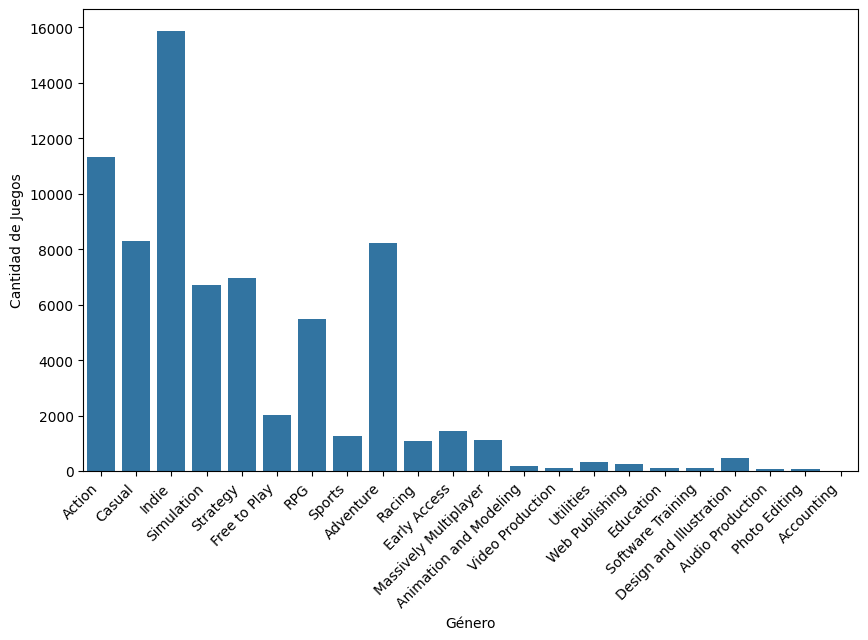

In [10]:
plt.figure(figsize = (10, 6))
sns.countplot(data = steamGamesGenresExplodedDf, x = 'genres', orient='h')
plt.ylabel('Cantidad de Juegos')
plt.xlabel('Género')
plt.xticks(rotation=45, ha='right')
plt.show()

Verificamos el conteo de géneros y el porcentaje apoyándomos de la función dataPercentage.

In [11]:
dataPercentage(steamGamesGenresExplodedDf,'genres')

,Cantidad,Porcentaje
genres,,
Indie,15858,22.16
Action,11321,15.82
Casual,8282,11.57
Adventure,8243,11.52
Strategy,6957,9.72
Simulation,6699,9.36
RPG,5479,7.66
Free to Play,2031,2.84
Early Access,1462,2.04


Realizamos lo mismo para la columna de 'release_year'. En este caso los valores 0 fueron aquellos que no proporcionaron el dato del año de lanzamiento, o bien, se encontraba en un formato incorrecto.

In [12]:
dataPercentage(steamGamesGenresExplodedDf,'release_year')[:20]

,Cantidad,Porcentaje
release_year,,
2017,25101,35.08
2016,17690,24.72
2015,12272,17.15
2014,6367,8.90
2013,3017,4.22
2012,2109,2.95
2011,987,1.38
2010,663,0.93
0,543,0.76


Creamos un gráfico que nos muestre la cantidad de juegos lanzados por año.

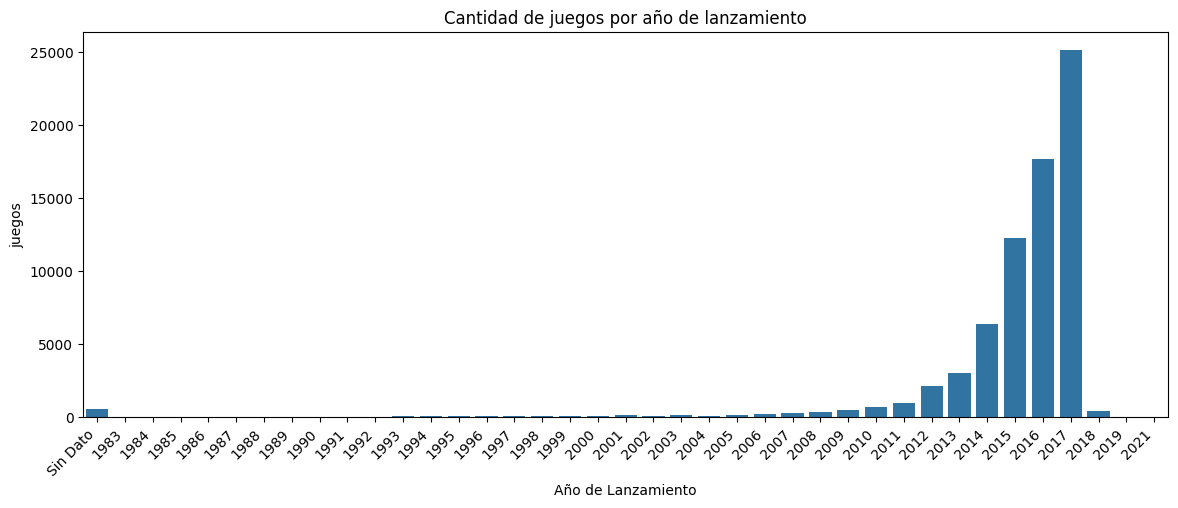

In [13]:
# Cuenta la frecuencia de cada año
yearCount = steamGamesGenresExplodedDf['release_year'].value_counts().sort_index().rename(index={0: 'Sin Dato'})
# Crear la gráfica de barras
plt.figure(figsize=(14, 5))
sns.barplot(x=yearCount.index, y=yearCount.values)
plt.xlabel('Año de Lanzamiento') ; plt.ylabel('juegos')
plt.title('Cantidad de juegos por año de lanzamiento')
plt.xticks(rotation=45, ha='right')
plt.show()

<h3>Steam Games Prices

Creamos un gráfico que nos muestre la distribución de los precios

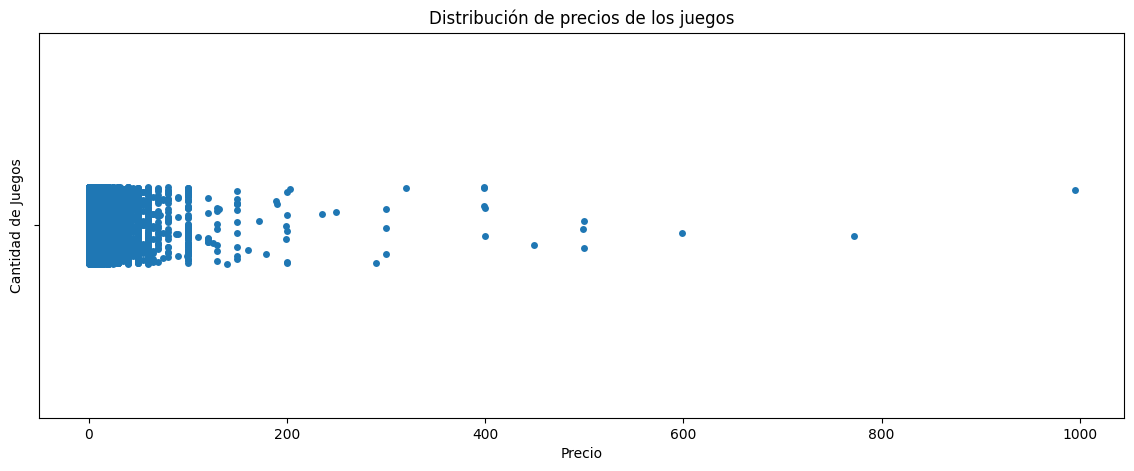

In [14]:
# Creamos un dataframe que contenga los id únicos de los juegos y su respectivo precio
pricesDf = steamGamesPriceDf.groupby('item_id')['price'].unique().reset_index().explode('price')
# Gráfico de dispersión
plt.figure(figsize=(14, 5))
sns.stripplot(data=pricesDf, x='price')
plt.xlabel('Precio')
plt.ylabel('Cantidad de Juegos')
plt.title('Distribución de precios de los juegos')
# Mostrar el gráfico
plt.show()

Obtenemos las medidas de tendencia central para los precios de los juegos.

In [15]:
stats = pricesDf['price'].astype(float).describe()
print(f'El precio medio (mediana) de los juegos es de: {stats[5]}')
print(f'El precio promedio (mean) de los juegos es de: {round(stats[1],2)}')
print(f'El 75% de los juegos tienen un precio menor de: {stats[6]}')

El precio medio (mediana) de los juegos es de: 4.99
El precio promedio (mean) de los juegos es de: 8.9
El 75% de los juegos tienen un precio menor de: 9.99


<h2>Dataset userItems

Cargamos los datasets y creamos los dataframes correspondientes.

In [16]:
userItemsExplodedDf = pd.read_parquet('../data/userItemsExploded.parquet')
userItemCountDf = pd.read_parquet('../data/userItemCount.parquet')

In [17]:
userItemsExplodedDf.head()

,user_id,item_id,playtime
0,76561197970982479,10,0.10
1,76561197970982479,20,0.00
2,76561197970982479,30,0.12
3,76561197970982479,40,0.00
4,76561197970982479,50,0.00


In [18]:
userItemCountDf.head()

,user_id,items_count
0,76561197970982479,277
1,js41637,888
2,evcentric,137
3,Riot-Punch,328
4,doctr,541


Creamos un gráfico que nos permita ver la acumulación de horas jugadas por usuario.

Text(0.5, 1.0, 'Acumulación de horas jugadas')

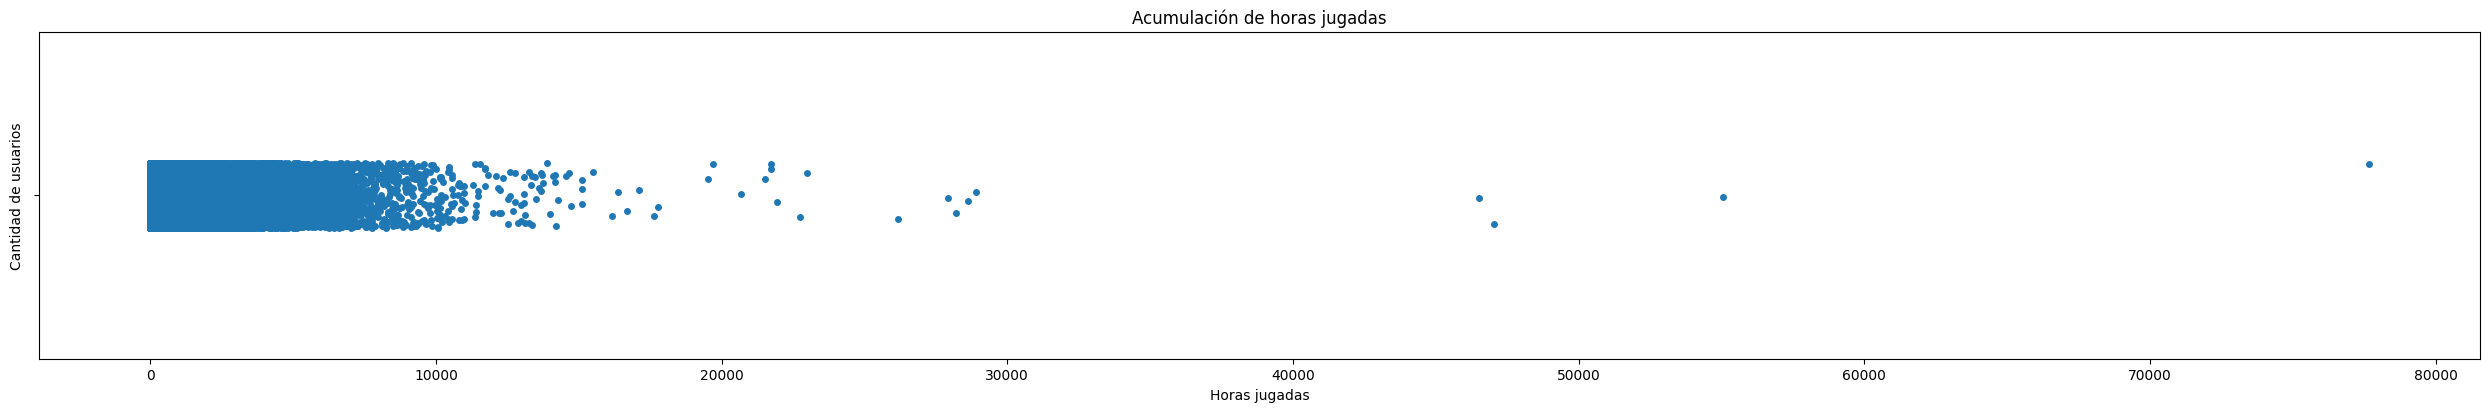

In [19]:
hoursPlayed = userItemsExplodedDf.groupby('user_id')['playtime'].sum().reset_index()
plt.figure(figsize=(25, 4))
sns.stripplot(data= hoursPlayed, x='playtime')
plt.xlabel('Horas jugadas')
plt.ylabel('Cantidad de usuarios')
plt.tight_layout()
plt.title('Acumulación de horas jugadas')

In [20]:

userItemsExplodedDf.groupby('user_id')['playtime'].sum().sort_values( ascending=False)

user_id
REBAS_AS_F-T         77673.29
shinomegami          55058.33
Sp3ctre              47047.69
DownSyndromeKid      46506.40
Terminally-Chill     28900.07
                       ...   
76561198095784353        0.00
76561198095815730        0.00
76561198095817502        0.00
76561198032143135        0.00
76561198065875604        0.00
Name: playtime, Length: 87626, dtype: float64

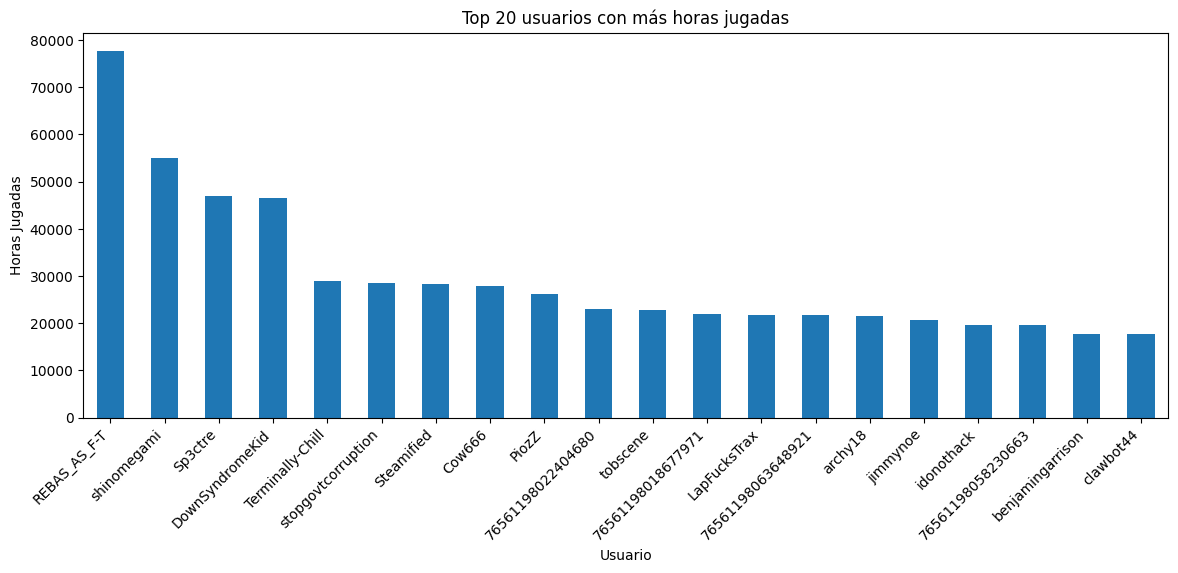

In [21]:
plt.figure(figsize=(14, 5))
userItemsExplodedDf.groupby('user_id')['playtime'].sum().sort_values(ascending=False)[:20].plot(kind='bar')
plt.xlabel('Usuario')
plt.ylabel('Horas Jugadas')
plt.title('Top 20 usuarios con más horas jugadas')
plt.xticks(rotation=45, ha='right')
plt.show()

Obtenemos las medidas de tendencia central del tiempo de juego.

In [22]:
stats = userItemsExplodedDf['playtime'].astype(float).describe()
print(f'El tiempo de juego medio (mediana) de los juegos es de: {stats[5]} horas')
print(f'El tiempo de juego promedio (mean) de los juegos es de: {round(stats[1],2)} horas')
print(f'El 75% de los juegos tienen un tiempo de juego menor de: {stats[6]} horas')

El tiempo de juego medio (mediana) de los juegos es de: 0.57 horas
El tiempo de juego promedio (mean) de los juegos es de: 16.52 horas
El 75% de los juegos tienen un tiempo de juego menor de: 5.92 horas


<h3> User Item Count

Creamos un gráfico que nos permita ver la cantidad de juegos por usuario.

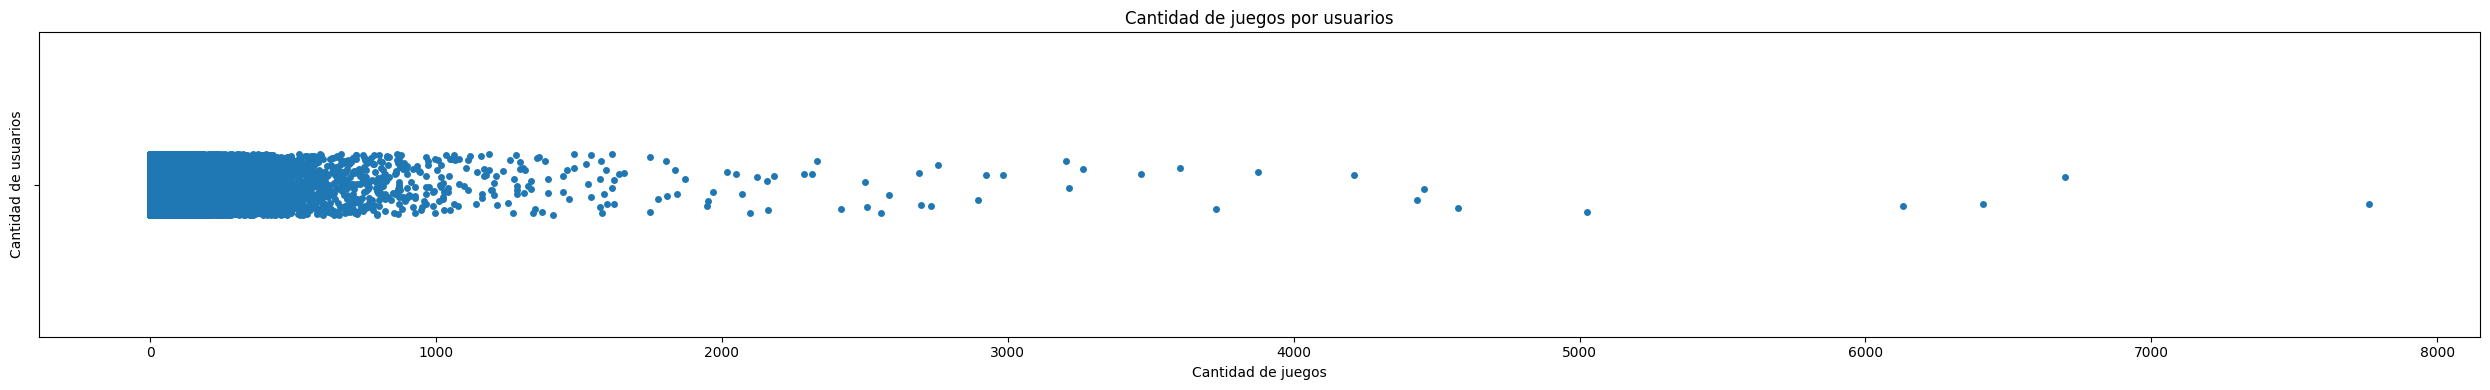

In [23]:
# Agrupa por usuario la cantidad de items, lo conviente en data frame y los ordena de mayor a menor
userItemCountDf = userItemCountDf.sort_values('items_count', ascending=False)
plt.figure(figsize=(25, 4))
sns.stripplot(data=userItemCountDf, x='items_count')
plt.xlabel('Cantidad de juegos')
plt.ylabel('Cantidad de usuarios')
plt.title('Cantidad de juegos por usuarios')
plt.tight_layout()
plt.show()

Obtenemos las medidas de tendencia central de la cantidad de juegos por usuario.

In [24]:
stats = userItemCountDf['items_count'].astype(float).describe()
print(f'La cantidad media (mediana) de items por persona es de: {stats[5]}')
print(f'La cantidad promedio (mean) de items por persona es de: {round(stats[1],2)}')
print(f'El 75% de las personas tienen un total de items menor a: {stats[6]}')

La cantidad media (mediana) de items por persona es de: 26.0
La cantidad promedio (mean) de items por persona es de: 58.35
El 75% de las personas tienen un total de items menor a: 73.0


<Figure size 1400x500 with 0 Axes>

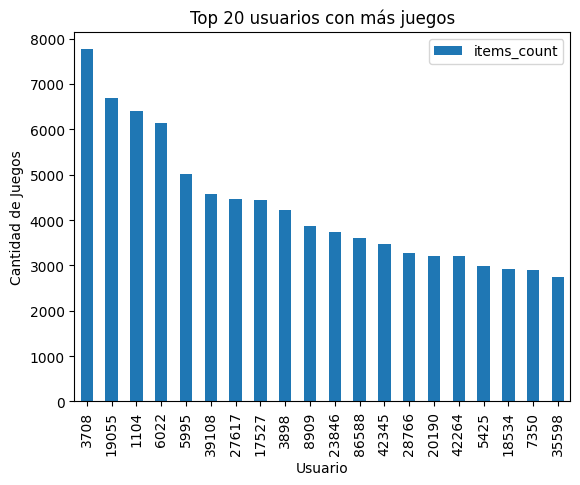

In [25]:
plt.figure(figsize=(14, 5))
userItemCountDf[:20].plot(kind='bar')
plt.xlabel('Usuario')
plt.ylabel('Cantidad de Juegos')
plt.title('Top 20 usuarios con más juegos')
plt.show()

<H2>Dataset userReviews

Se leen los datasets y se crean los dataframes correspondientes.

In [26]:
userReviewsDf=pd.read_parquet('../data/userReviews.parquet')
userReviewsExplodedDf=pd.read_parquet('../data/userReviewsExploded.parquet')

In [27]:
userReviewsDf.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'helpful': 'No ratings yet', 'i..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'helpful': '15 of 20 people (75..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'helpful': 'No ratings yet', 'i..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'helpful': '2 of 2 people (100%..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [28]:
userReviewsExplodedDf.head()

,user_id,recommend,item_id,review_date,review_year,sentiment_analysis
0,76561197970982479,True,1250,2011-11-05,2011,2
1,76561197970982479,True,22200,2011-07-15,2011,2
2,76561197970982479,True,43110,2011-04-21,2011,2
3,js41637,True,251610,2014-06-24,2014,2
4,js41637,True,227300,2013-09-08,2013,2


Observamos que existen datos nulos en las columnas de review_date y review_year.

In [29]:
userReviewsExplodedDf.sort_values(by='review_year')

,user_id,recommend,item_id,review_date,review_year,sentiment_analysis
41068,76561197988318026,True,440,2010-12-18,2010,2
29807,farsel,True,24010,2010-11-19,2010,2
29806,farsel,True,8800,2010-11-24,2010,2
9683,76561198023634778,True,440,2010-11-26,2010,2
29802,farsel,True,12900,2010-11-26,2010,2
...,...,...,...,...,...,...
59300,76561198312638244,True,70,NaT,<NA>,2
59301,76561198312638244,True,362890,NaT,<NA>,2
59302,LydiaMorley,True,273110,NaT,<NA>,2
59303,LydiaMorley,True,730,NaT,<NA>,2


In [30]:
dataType(userReviewsExplodedDf)

,name,data_type,not_null_%,null_%,null
0,user_id,[<class 'str'>],100.00,0.00,0
1,recommend,[<class 'bool'>],100.00,0.00,0
2,item_id,[<class 'str'>],100.00,0.00,0
3,review_date,[<class 'pandas._libs.tslibs.timestamps.Timest...,82.94,17.06,10119
4,review_year,"[<class 'int'>, <class 'pandas._libs.missing.N...",82.94,17.06,10119
5,sentiment_analysis,[<class 'str'>],100.00,0.00,0


In [31]:
userReviewsExplodedDf['review_year'].unique()

<IntegerArray>
[2011, 2014, 2013, <NA>, 2015, 2012, 2010]
Length: 7, dtype: Int64

Del dataframe userReviews extraemos un ejemplo de la reseña de un usuario que cuenta con datos de fecha nulos en el dataframe userReviewsExploded. Se concluye que los registros al no tener año fueron probablemente publicados el año del corte.

In [32]:
reviews = userReviewsDf[userReviewsDf['user_id'] == '76561198312638244']['reviews'].explode().reset_index(drop=True)
response = (pd.DataFrame(reviews)).iloc[3,0]
print(response['posted'])

Posted July 8.


Se revisan los porcentajes de datos de las columnas 'sentiment_analysis' y 'recommend'

In [33]:
dataPercentage(userReviewsExplodedDf,'sentiment_analysis')

,Cantidad,Porcentaje
sentiment_analysis,,
2,37417,63.09
1,12276,20.70
0,9612,16.21


In [34]:
dataPercentage(userReviewsExplodedDf,'recommend')

,Cantidad,Porcentaje
recommend,,
True,52473,88.48
False,6832,11.52


Se crea un dataframe que nos muestre las combinaciones de análisis de sentimiento y recomendación, tanto sus conteos como sus porcentajes.

In [35]:
# Dataframe agrupado
groupedDf = userReviewsExplodedDf.groupby(['sentiment_analysis', 'recommend'])
# Cantidad de reviews
groupedDfSize = groupedDf.size()
# Porcentaje
groupedDfPercent = 100 * groupedDf.size() / len(userReviewsExplodedDf)
# Resumen
recommendAnalysis = pd.DataFrame({
    "Cantidad": groupedDfSize,
    "Porcentaje": groupedDfPercent
})
recommendAnalysis

Cantidad  Porcentaje
sentiment_analysis recommend                      
0                  False          2913    4.911896
                   True           6699   11.295844
1                  False          1488    2.509063
                   True          10788   18.190709
2                  False          2431    4.099148
                   True          34986   58.993340

Se consulta la cantidad de usuarios únicos que comentaron.

In [36]:
len(userReviewsExplodedDf['user_id'].unique())

25458

Creamos una gráfica con la cantidad de reseñas por fecha utilizando un dataframe que no contenga las reseñas con datos de fecha nulos.

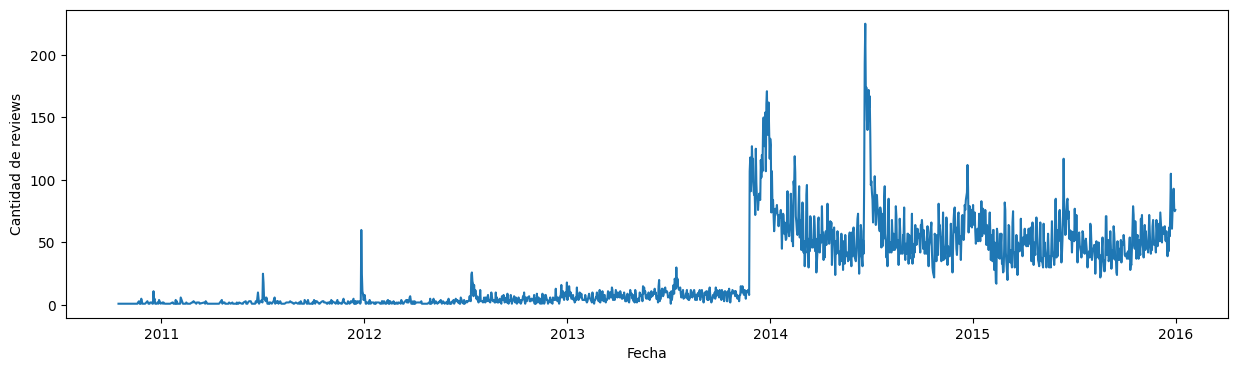

In [37]:
# Dataframe sin datos nulos
df = pd.DataFrame(userReviewsExplodedDf.dropna())
# Agrupación por 'review_date'
dfCounts = df.groupby('review_date').count()
# Creación de gráfica
plt.figure(figsize = (15, 4))
sns.lineplot(data = dfCounts, x = 'review_date', y = 'recommend')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de reviews')
plt.show()

<h2>Preparación Machine Learning

Se propone crear un modelo de recomendación item-item en donde se ingrese el nombre de un juego y recomienden juegos similares. Para esto se tomarán en cuenta la similitud en cuanto a género, el porcentaje de recomendación, la puntuación de sentimiento promedio, y el número de reseñas.

In [38]:
userReviewsExplodedDf = pd.read_parquet('../data/userReviewsExploded.parquet')
userReviewsExplodedDf = userReviewsExplodedDf[['user_id', 'item_id', 'recommend', 'sentiment_analysis']]
steamGamesGenresDf = pd.read_parquet('../data/steamGamesGenres.parquet')
steamGamesGenresDf = steamGamesGenresDf[['item_id', 'genres']]
steamGamesDf = pd.read_parquet('../data/steamGames.parquet')
steamGamesDf = steamGamesDf[['item_id', 'app_name']]

In [39]:
steamGamesDf.head()

,item_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


In [40]:
userReviewsExplodedDf.head()

,user_id,item_id,recommend,sentiment_analysis
0,76561197970982479,1250,True,2
1,76561197970982479,22200,True,2
2,76561197970982479,43110,True,2
3,js41637,251610,True,2
4,js41637,227300,True,2


In [41]:
steamGamesGenresDf.head()

,item_id,genres
0,761140,"[Action, Casual, Indie, Simulation, Strategy]"
1,643980,"[Free to Play, Indie, RPG, Strategy]"
2,670290,"[Casual, Free to Play, Indie, Simulation, Sports]"
3,767400,"[Action, Adventure, Casual]"
4,772540,"[Action, Adventure, Simulation]"


Se realizan las transformaciones correspondiente y se crea un dataframe para ser utilizado por el modelo de recomendación.

In [42]:
# Se convierte el análisis de sentimiento a tipo int
userReviewsExplodedDf['sentiment_analysis'] = userReviewsExplodedDf['sentiment_analysis'].astype(int)
# Se crea un dataframe uniendo las reseñas a los juegos correspondientes
machineLearningDf = pd.merge(userReviewsExplodedDf, steamGamesDf, how='left', on='item_id')

In [43]:
machineLearningDf.head()

,user_id,item_id,recommend,sentiment_analysis,app_name
0,76561197970982479,1250,True,2,Killing Floor
1,76561197970982479,22200,True,2,Zeno Clash
2,76561197970982479,43110,True,2,NaN
3,js41637,251610,True,2,NaN
4,js41637,227300,True,2,Euro Truck Simulator 2


Verificamos los datos nulos y eliminamos los juegos que no tienen nombre asignado.

In [44]:
dataType(machineLearningDf)

,name,data_type,not_null_%,null_%,null
0,user_id,[<class 'str'>],100.00,0.00,0
1,item_id,[<class 'str'>],100.00,0.00,0
2,recommend,[<class 'bool'>],100.00,0.00,0
3,sentiment_analysis,[<class 'int'>],100.00,0.00,0
4,app_name,"[<class 'str'>, <class 'float'>]",91.03,8.97,5317


In [45]:
machineLearningDf = machineLearningDf.dropna(subset='app_name')

Se aplica la función recommendScore, la cual descarta los reviews que no recomiendan el juego, y luego les asigna una calificación dependiendo del análisis de sentimiento de los comentarios.

In [46]:
machineLearningDf['score'] = machineLearningDf.apply(recommendScore, axis=1)
machineLearningDf = machineLearningDf[['user_id', 'app_name', 'score']]
machineLearningDf.head()

,user_id,app_name,score
0,76561197970982479,Killing Floor,3
1,76561197970982479,Zeno Clash,3
4,js41637,Euro Truck Simulator 2,3
5,js41637,"Papers, Please",3
6,evcentric,Risk of Rain,3


In [47]:
dataType(machineLearningDf)

,name,data_type,not_null_%,null_%,null
0,user_id,[<class 'str'>],100.0,0.0,0
1,app_name,[<class 'str'>],100.0,0.0,0
2,score,[<class 'int'>],100.0,0.0,0


Creamos un dataframe que contiene los 'user_id' como idices, los juegos ('app_name') como columnas y como valores los 'score'.

In [48]:
machineLearningDf = machineLearningDf.pivot_table(index=['user_id'], columns=['app_name'], values='score')
machineLearningDf

app_name,! That Bastard Is Trying To Steal Our Gold !,//N.P.P.D. RUSH//- The milk of Ultraviolet,0RBITALIS,"10,000,000",100% Orange Juice,100% Orange Juice - Krila & Kae Character Pack,1001 Spikes,12 Labours of Hercules,12 Labours of Hercules II: The Cretan Bull,12 is Better Than 6,...,nail'd,oO,planetarian ~the reverie of a little planet~,resident evil 4 / biohazard 4,sZone-Online,the static speaks my name,theBlu,theHunter Classic,theHunter: Primal,Астролорды: Облако Оорта
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ace--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ionex--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2SV-vuLB-Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Azsael-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zvanik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zwanzigdrei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zy0705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lo guardamos como parquet para ser utilizado en el modelo de aprendizaje.

In [49]:
machineLearningDf.to_parquet('../data/machineLearning.parquet', index=True)